# Lab CNNs

## Integrantes
- Jose Asitimbay
- Brayan Lechon

# Activities

- Create a CCN model to predict the next word in a sentence. 
- Use Cien años de soledad by Gabriel Garcia Marquez as the training text. 

In [81]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from pathlib import Path

adaptamos el codigo de la clase para que funcione con cuda

In [82]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(f"GPU encontrada: {torch.cuda.get_device_name(0)}")

GPU encontrada: NVIDIA GeForce RTX 4060 Laptop GPU


## Dataset

In [83]:
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

In [84]:
path_data = Path('./data/gabriel_garcia_marquez_cien_annos_soledad.txt')
text = open(path_data, 'r', encoding='utf-8').read().lower()

In [85]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    #tokens = [ss.stem(w) for w in tokens if w not in sw]
    return tokens


In [86]:
tokens = split_tokens(text)

In [127]:
print(tokens[:5])

['gabriel', 'garcía', 'márquez', 'cien', 'años']


In [88]:
counts = Counter(tokens)

In [128]:
for i, (k, v) in enumerate(counts.items()):
    print(k, v)
    if i == 5:
        break

gabriel 184
garcía 173
márquez 241
cien 182
años 357
soledad 217


In [90]:
counts_more_than_1 = {k:v for k,v in counts.items() if v > 1}

In [91]:
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v:k for k,v in itot.items()}

In [92]:
tokens_more_than_1 = [w for w in tokens if w in vocab]

### Let's prepare the window for word2vec

In [93]:
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i+j] for j in range(-win, win+1,1) 
                  if (i+j >= 0) & (i+j < len(tokens)) & (j != 0)]
       # print(window)
        output += [(target, ttoi[j]) for j in window]
    return output

In [94]:
data_windowed = window(tokens_more_than_1, win=4)

In [129]:
data_windowed[:5]

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 0)]

In [96]:
class text_dataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x =  F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y


In [97]:
dataset = text_dataset(data_windowed, len(vocab))

In [98]:
#sanity check
for i in range(5):
    print(dataset[i])

(tensor([1, 0, 0,  ..., 0, 0, 0]), 1)
(tensor([1, 0, 0,  ..., 0, 0, 0]), 2)
(tensor([1, 0, 0,  ..., 0, 0, 0]), 3)
(tensor([1, 0, 0,  ..., 0, 0, 0]), 4)
(tensor([0, 1, 0,  ..., 0, 0, 0]), 0)


## Baseline Neural Network

In [99]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input.to(torch.int64))
        logits = self.expand(hidden)
        return logits

In [100]:
model = Word2Vec(len(vocab), 100)

In [101]:
model

Word2Vec(
  (embed): Embedding(7406, 100)
  (expand): Linear(in_features=100, out_features=7406, bias=False)
)

In [102]:
LR = 3e-3
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [103]:
from tqdm.auto import tqdm  # For progress bars

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)
        center = center.to(device).float()
        context = context.to(device).float()
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)
    
progress_bar.close()


  0%|          | 0/77490 [00:00<?, ?it/s]

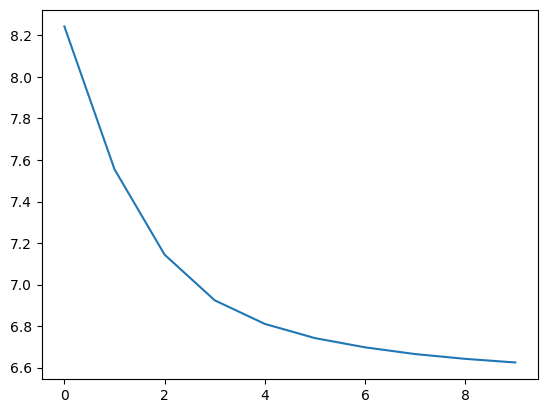

In [104]:
plt.plot(running_loss)

In [105]:
wordvecs = model.expand.weight.cpu().detach().numpy()

In [106]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

# n * (n-1) / 2
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

In [107]:
dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']
# tokens_test = [ss.stem(w) for w in tokens_test if w not in sw]
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")

aureliano ['segundo', 'coronel', 'buendía', 'arcadio', 'úrsula', 'casa', 'josé', 'dijo', 'márquez', 'mientras'] 

coronel ['gerineldo', 'buendía', 'márquez', 'aureliano', 'condenado', 'promovió', 'mando', 'confidencial', 'general', 'moneada'] 

macondo ['habitantes', 'primeros', 'sierra', 'llegado', 'políticas', 'según', 'fundación', 'llegaron', 'talleres', 'vagones'] 

casa ['úrsula', 'aureliano', 'mientras', 'después', 'andaba', 'fernanda', 'dijo', 'hizo', 'si', 'segundo'] 

pueblo ['cobrar', 'respaldo', 'falsos', 'dispensarios', 'rosados', 'proclamas', 'ordenaron', 'señorial', 'vano', 'escapaba'] 

melquíades ['claves', 'demonio', 'ciencia', 'desenterrar', 'mágicos', 'distracción', 'tribu', 'laboratorio', 'lupa', 'prodigioso'] 

arcadio ['josé', 'buendía', 'aureliano', 'segundo', 'hizo', 'rebeca', 'lanza', 'torrencial', 'aldea', 'empecinó'] 

úrsula ['amaranta', 'casa', 'aureliano', 'dijo', 'tan', 'dos', 'cuenta', 'vez', 'fernanda', 'tiempo'] 



## CNN

In [118]:
class CNNWord2Vec(nn.Module):
    def __init__(self, vocab_size, hidden_size=100):
        super().__init__()
        self.vocab_size = vocab_size
        self.conv = nn.Conv1d(in_channels=vocab_size, out_channels=hidden_size, kernel_size=1)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):

        x = x.unsqueeze(-1)     
        conv_out = F.relu(self.conv(x))  
        conv_out = conv_out.squeeze(-1)  
        logits = self.fc(conv_out )  
        
        return logits

In [119]:
model = CNNWord2Vec(len(vocab), hidden_size=100)
model = model.to(device)

In [120]:
LR = 3e-3
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [121]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for context, center in dataloader:
        context = context.to(device).float()
        center = center.to(device).long()  
        
        optimizer.zero_grad()
        logits = model(context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)

    progress_bar.set_description(f"Época {epoch+1}/{EPOCHS}, Pérdida: {epoch_loss:.4f}")

progress_bar.close()

  0%|          | 0/77490 [00:00<?, ?it/s]

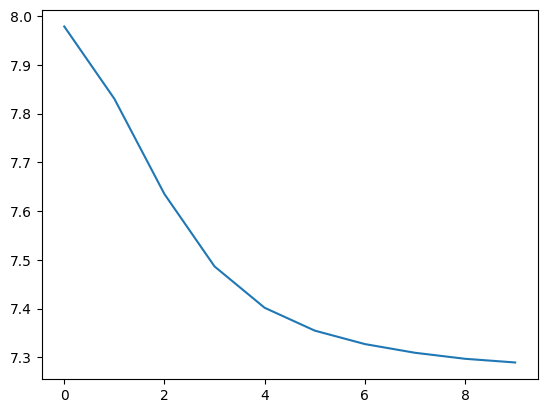

In [122]:
plt.plot(running_loss)

In [125]:
wordvecs = model.fc.weight.cpu().detach().numpy()

In [130]:
wordvecs

array([[-7.2928686e-03, -6.3257685e+00, -5.1353841e+00, ...,
         2.4582796e+00, -1.4990793e+00, -1.4409471e-03],
       [ 5.1121772e-03, -3.6389933e+00, -3.1030252e+00, ...,
         2.3160658e+00, -9.3804038e-01,  3.1952057e-03],
       [-9.3422206e-03, -2.4109969e+00, -3.9163914e+00, ...,
         1.4485216e+00, -7.6781946e-01, -5.8908467e-03],
       ...,
       [-2.7680886e-03, -1.9162210e+01, -1.7685390e+01, ...,
        -2.2124601e+01, -2.8930202e+01, -1.1004140e-02],
       [-6.7342154e-04, -1.7834984e+01, -1.6277922e+01, ...,
        -1.3508459e+00, -2.7195955e+01, -3.7469278e-04],
       [ 7.4866945e-03, -1.7508488e+01, -1.6439016e+01, ...,
        -2.0568800e+00, -2.7650387e+01, -1.0822445e-02]], dtype=float32)

In [126]:
dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']
# tokens_test = [ss.stem(w) for w in tokens_test if w not in sw]
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")

aureliano ['casa', 'entonces', 'úrsula', 'noche', 'dos', 'vio', 'sólo', 'tiempo', 'volvió', 'alarmó'] 

coronel ['entonces', 'dijo', 'úrsula', 'guerra', 'vio', 'aureliano', 'casa', 'volvió', 'segundo', 'gerineldo'] 

macondo ['tiempo', 'tan', 'después', 'guerra', 'padre', 'sólo', 'sino', 'burlarse', 'vida', 'mandaran'] 

casa ['úrsula', 'mientras', 'sólo', 'tiempo', 'aquella', 'dos', 'vio', 'meses', 'sino', 'fernanda'] 

pueblo ['podía', 'hombre', 'misma', 'aquella', 'tiempo', 'macondo', 'úrsula', 'fernanda', 'ningún', 'amaranta'] 

melquíades ['úrsula', 'hombres', 'entonces', 'sino', 'amor', 'mientras', 'siempre', 'realidad', 'noche', '76'] 

arcadio ['josé', 'empecinó', 'inmutarse', 'segundo', 'tiempo', 'casa', 'mientras', 'impaciencia', 'sacudido', 'inventar'] 

úrsula ['casa', 'sólo', 'entonces', 'mientras', 'hombre', 'mismo', 'fernanda', 'noche', 'dos', 'aquella'] 



# Conclusion